In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/LICENSE
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/readme.md
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/r2_162_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/r_305_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/139_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/128_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/r2_297_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/r2_304_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/r_239_100.jpg
/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/Melon Piel de Sapo 1/r2_308_100.jpg
/kaggle/input/fruits/fruits-360_dataset_

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Essayez ces chemins
train_dir = "/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training"
test_dir = "/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test"

# Vérifiez si les dossiers existent
print("Training existe:", os.path.exists(train_dir))
print("Test existe:", os.path.exists(test_dir))

# Transforms pour le prétraitement
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Charger les datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(test_dir, transform=data_transforms["val"])

# Créer les DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Nombre de classes : {len(train_dataset.classes)}")
print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
print(f"Taille du dataset de validation : {len(val_dataset)}")

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# Charger ResNet-18 pré-entraîné
model = resnet18(weights=ResNet18_Weights.DEFAULT)



# Geler les couches convolutives (optionnel pour le fine-tuning)
for param in model.parameters():
    param.requires_grad = False  # Ne pas entraîner les couches existantes

# Remplacer la dernière couche pour s'adapter à vos classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Déplacer le modèle sur le GPU
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Optimiser uniquement la dernière couche
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Planificateur de LR

In [34]:
from tqdm import tqdm


In [35]:
!pip install tqdm


In [36]:
# Nombre d'époques
num_epochs = 5

for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    running_loss = 0.0
    running_corrects = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Mode évaluation
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    print("-" * 50)

    # Mise à jour du scheduler
    scheduler.step()


Epoch 1/5


Validation: 100%|██████████| 739/739 [04:30<00:00,  2.73it/s]


Train Loss: 0.9792 Acc: 0.7994
Val Loss: 0.1841 Acc: 0.9605
--------------------------------------------------

Epoch 2/5


Validation: 100%|██████████| 739/739 [01:22<00:00,  8.92it/s]


Train Loss: 0.3621 Acc: 0.9039
Val Loss: 0.1336 Acc: 0.9691
--------------------------------------------------

Epoch 3/5


Validation: 100%|██████████| 739/739 [01:22<00:00,  8.98it/s]


Train Loss: 0.2882 Acc: 0.9191
Val Loss: 0.0977 Acc: 0.9735
--------------------------------------------------

Epoch 4/5


Validation: 100%|██████████| 739/739 [01:36<00:00,  7.62it/s]


Train Loss: 0.2623 Acc: 0.9230
Val Loss: 0.0931 Acc: 0.9757
--------------------------------------------------

Epoch 5/5


Validation: 100%|██████████| 739/739 [01:22<00:00,  8.99it/s]

Train Loss: 0.2360 Acc: 0.9293
Val Loss: 0.0891 Acc: 0.9758
--------------------------------------------------


In [37]:
torch.save(model.state_dict(), "/kaggle/working/fruits360_resnet18.pth")

In [38]:
torch.save(model.state_dict(), "model.pth")
print("Modèle sauvegardé sous 'model.pth'")


Modèle sauvegardé sous 'model.pth'


In [44]:
# Sauvegarder le modèle + metadata
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
    'class_to_idx': train_dataset.class_to_idx,
    'classes': train_dataset.classes
}, "/kaggle/working/full_model_checkpoint.pth")

Using device: cuda


<ipython-input-29-6ac13a402f91>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Évaluation: 100%|██████████| 739/7


Performance finale:
Loss: 0.0891 | Accuracy: 0.9758
                       precision    recall  f1-score   support

              Apple 6       0.94      1.00      0.97       157
     Apple Braeburn 1       0.91      0.84      0.87       164
 Apple Crimson Snow 1       0.98      0.74      0.84       148
       Apple Golden 1       0.96      1.00      0.98       160
       Apple Golden 2       0.99      0.99      0.99       164
       Apple Golden 3       0.83      1.00      0.91       161
 Apple Granny Smith 1       1.00      0.95      0.97       164
    Apple Pink Lady 1       0.77      0.99      0.86       152
          Apple Red 1       0.73      0.84      0.78       164
          Apple Red 2       0.71      0.95      0.81       164
          Apple Red 3       1.00      0.92      0.96       144
Apple Red Delicious 1       1.00      1.00      1.00       166
   Apple Red Yellow 1       1.00      0.82      0.90       164
   Apple Red Yellow 2       1.00      1.00      1.00       219
 

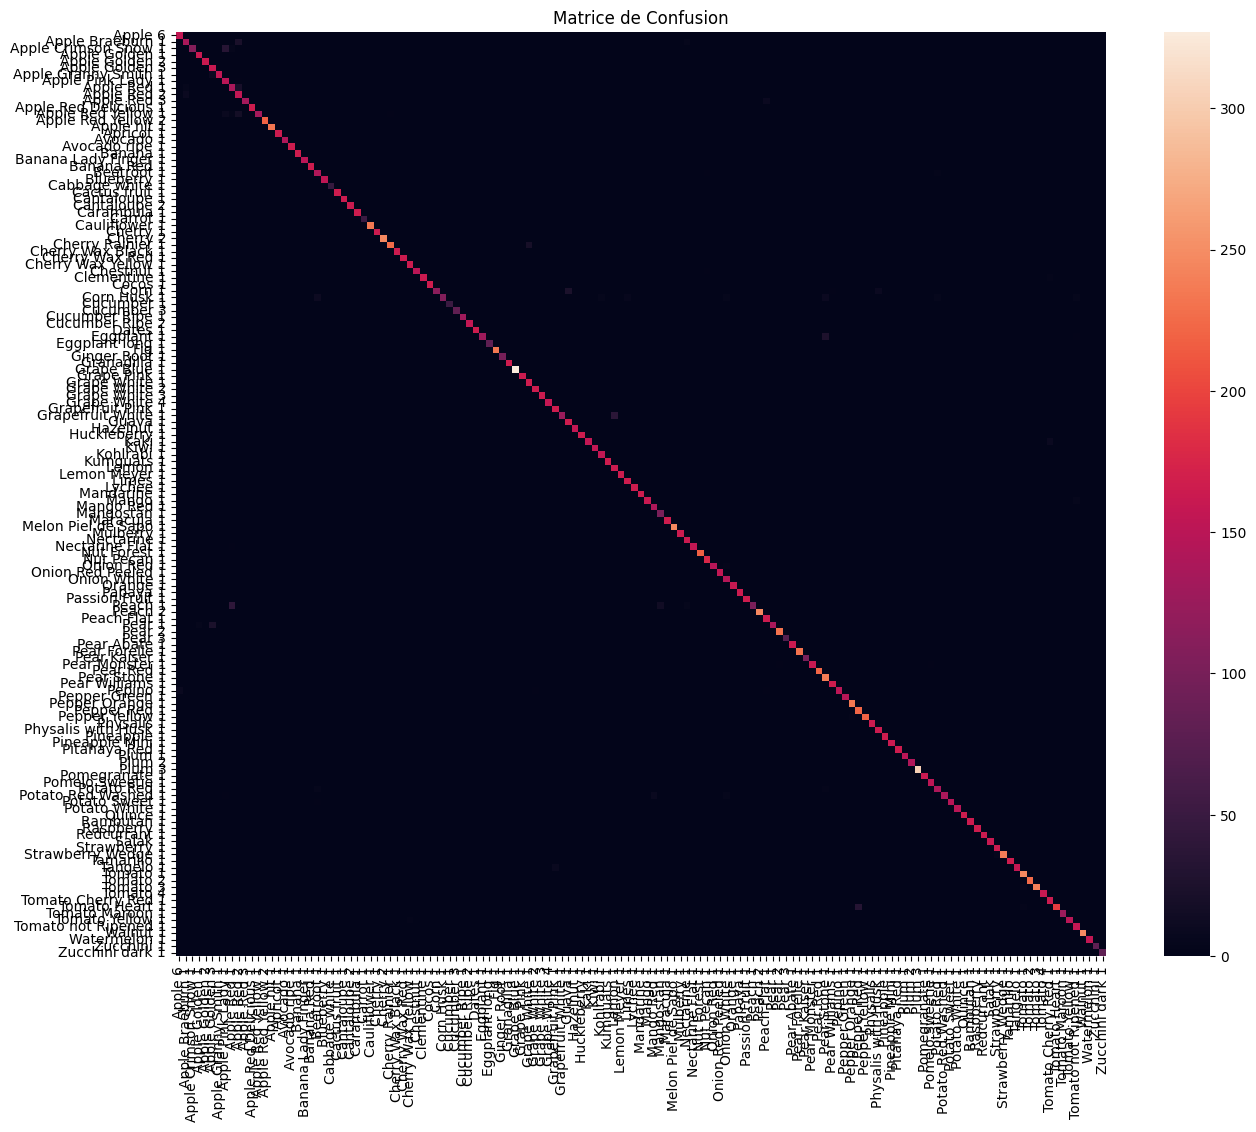


Top 5 prédictions:
Banana 1: 0.9735
Banana Lady Finger 1: 0.0262
Cucumber Ripe 1: 0.0002
Pepper Red 1: 0.0000
Tomato not Ripened 1: 0.0000


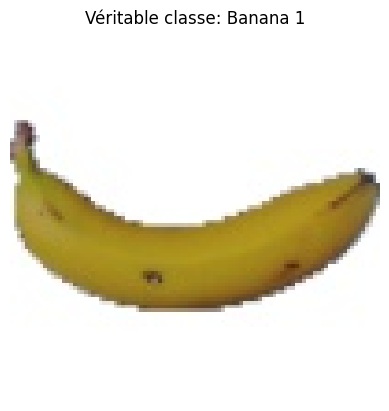


Top 5 prédictions:
Hazelnut 1: 1.0000
Cherry Wax Yellow 1: 0.0000
Granadilla 1: 0.0000
Pear 3: 0.0000
Chestnut 1: 0.0000


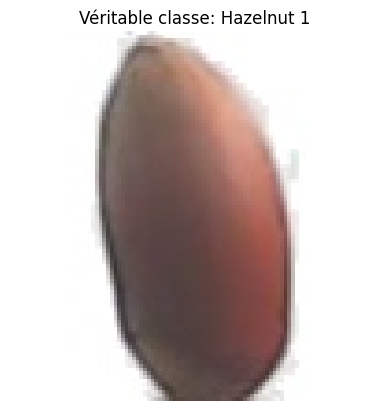


Top 5 prédictions:
Passion Fruit 1: 0.9984
Avocado ripe 1: 0.0015
Apple Red Delicious 1: 0.0001
Mango 1: 0.0000
Grape White 1: 0.0000


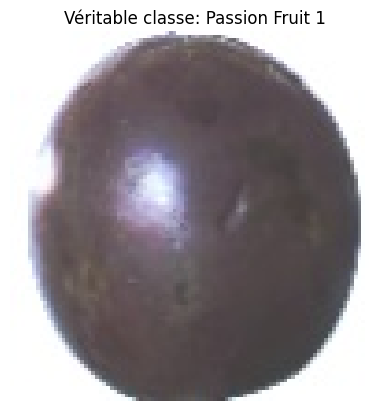

In [29]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# Configuration de base
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chemins IMPORTANTS à vérifier
model_path = "/kaggle/input/dataset/fruits360_resnet18.pth"
test_dir = "/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test"  # À confirmer!

# 1. Chargement du modèle
def load_model(model_path, num_classes):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # Chargement avec gestion du device
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
    except RuntimeError as e:
        print(f"Erreur de chargement: {e}")
        return None
    
    model = model.to(device)
    model.eval()
    return model

# 2. Préparation des données
def prepare_data(test_dir):
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return test_loader, test_dataset.classes

# 3. Évaluation complète
def evaluate_model(model, test_loader, class_names):
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Évaluation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            total_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcul des métriques
    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    print(f"\nPerformance finale:")
    print(f"Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Matrice de confusion
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=False, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice de Confusion')
    plt.show()

# 4. Test avec une image aléatoire
def test_random_image(model, test_dir, class_names, transform):
    random_class = np.random.choice(os.listdir(test_dir))
    random_image = np.random.choice(os.listdir(os.path.join(test_dir, random_class)))
    image_path = os.path.join(test_dir, random_class, random_image)
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
    
    _, top5_indices = torch.topk(probabilities, 5)
    top5_probs = probabilities[0][top5_indices[0]].cpu().numpy()
    top5_classes = [class_names[i] for i in top5_indices[0].cpu().numpy()]
    
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Véritable classe: {random_class}")
    print("\nTop 5 prédictions:")
    for cls, prob in zip(top5_classes, top5_probs):
        print(f"{cls}: {prob:.4f}")
    plt.show()

# Exécution principale
if __name__ == "__main__":
    # Charger les données
    test_loader, class_names = prepare_data(test_dir)
    num_classes = len(class_names)
    
    # Charger le modèle
    model = load_model(model_path, num_classes)
    
    if model:
        # Évaluation complète
        evaluate_model(model, test_loader, class_names)
        
        # Test visuel
        test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        for _ in range(3):  # Tester 3 images aléatoires
            test_random_image(model, test_dir, class_names, test_transform)

In [10]:
# Chemin vers le dataset
train_dir = "/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Training/"

# Compter les classes
num_classes = len(os.listdir(train_dir))
print(f"Nombre de classes détectées : {num_classes}")

# Si c'est 141 -> garder le modèle actuel
# Si c'est 131 -> corriger l'architecture

Nombre de classes détectées : 141


In [12]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 141)  # 141 classes

# Chargement strict
model.load_state_dict(
    torch.load(
        "/kaggle/input/dataset/fruits360_resnet18.pth",
        map_location="cpu",
        weights_only=True
    ),
    strict=True  # Vérification complète
)

<All keys matched successfully>

In [13]:
# Vérifier les dimensions
print("Dimension de fc.weight :", model.fc.weight.shape)
print("Dimension de fc.bias   :", model.fc.bias.shape)

# Test de prédiction
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)
print("\nShape de sortie :", output.shape)  # Doit être [1, nombre_classes]

Dimension de fc.weight : torch.Size([141, 512])
Dimension de fc.bias   : torch.Size([141])

Shape de sortie : torch.Size([1, 141])


Évaluation: 100%|██████████| 370/370 [01:31<00:00,  4.03it/s]



Accuracy globale: 97.58%


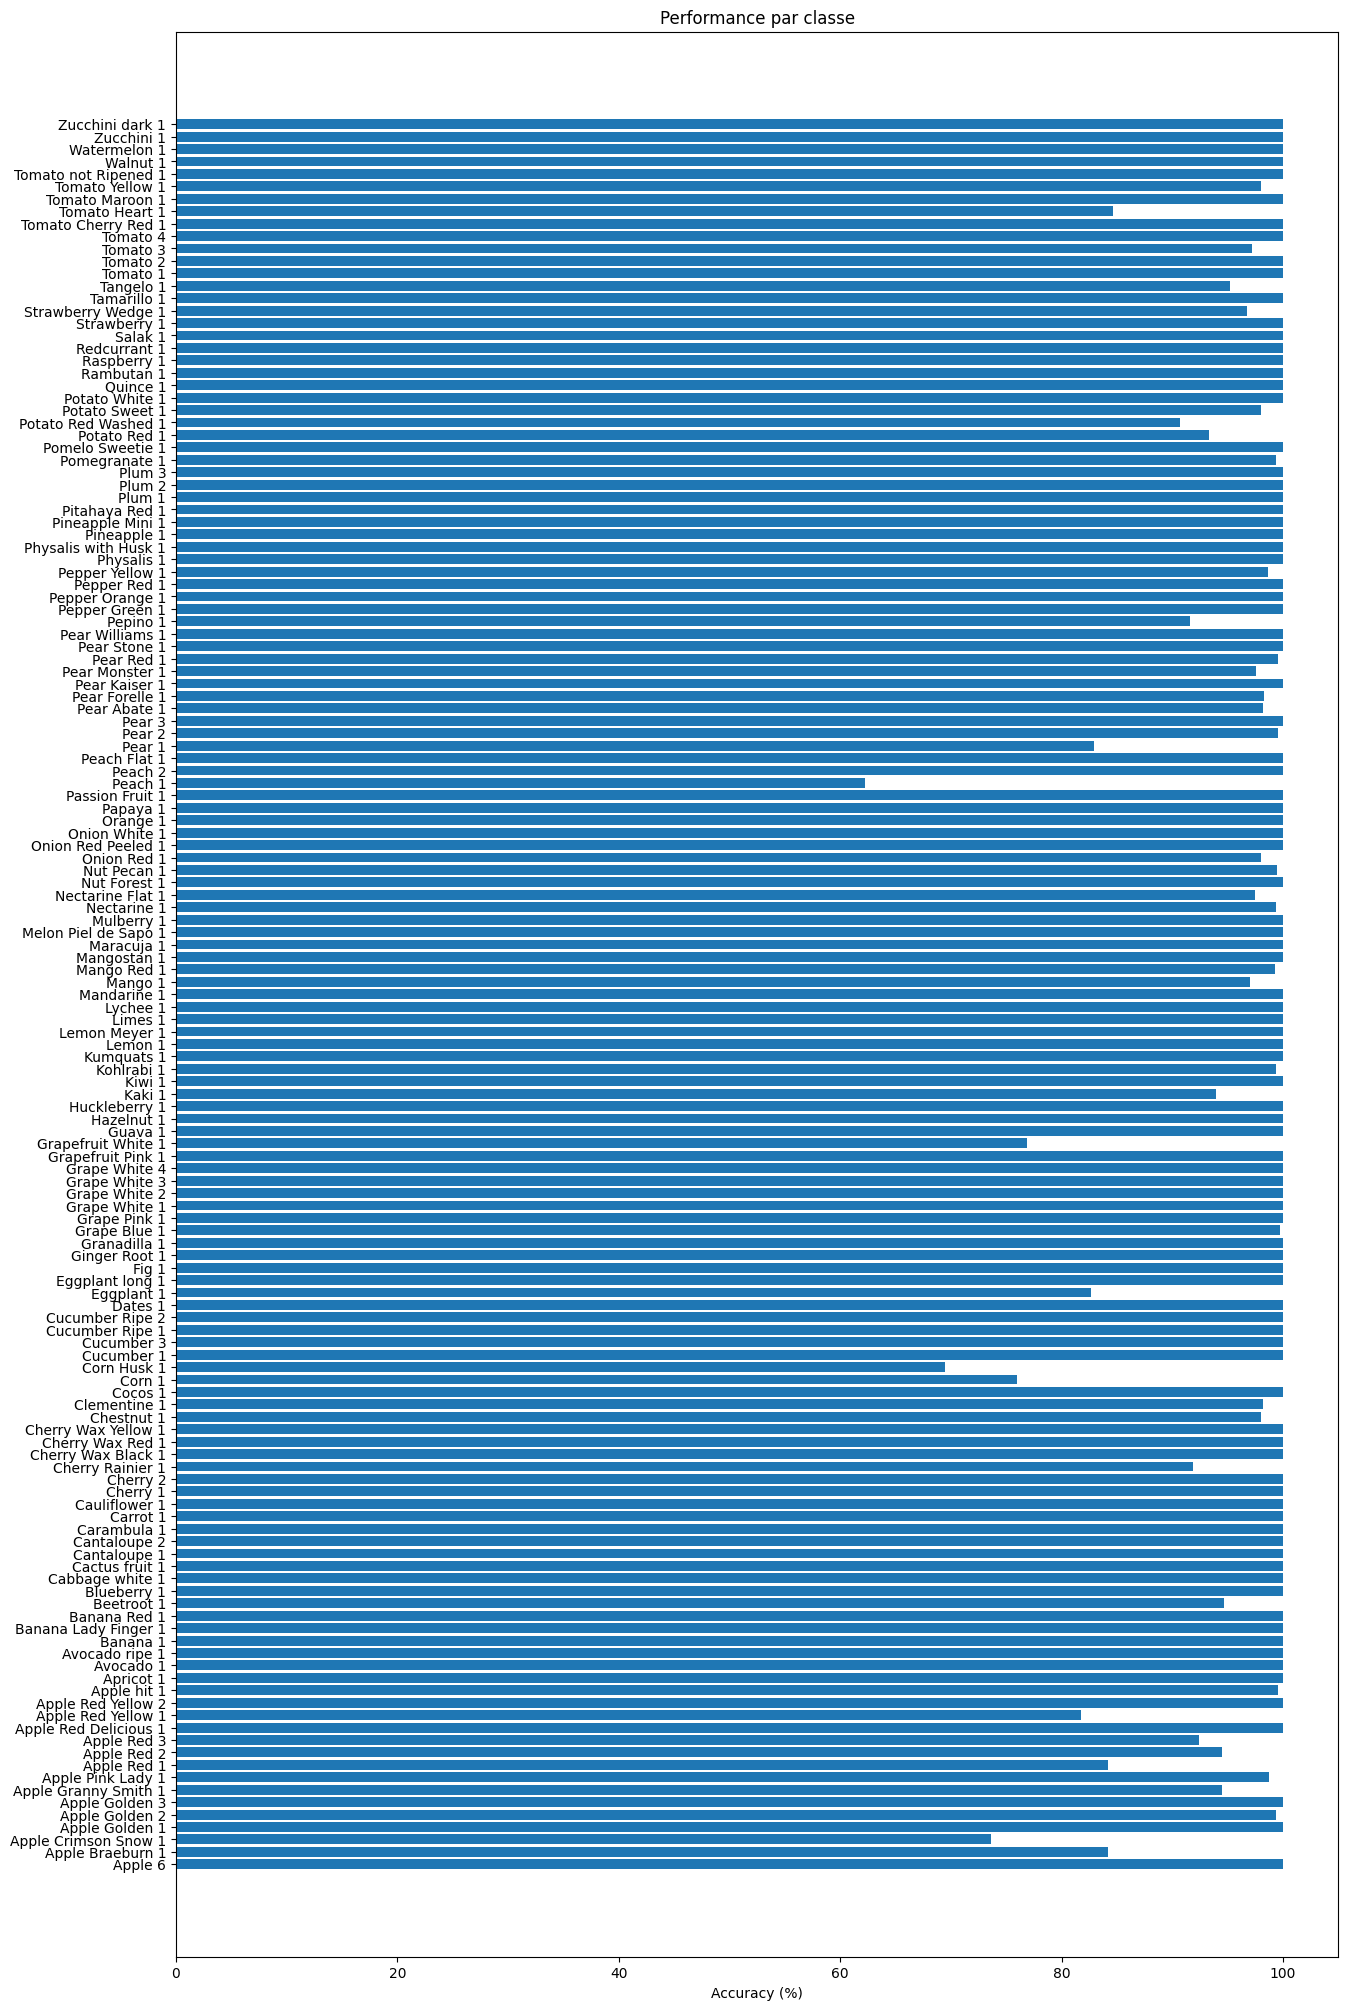

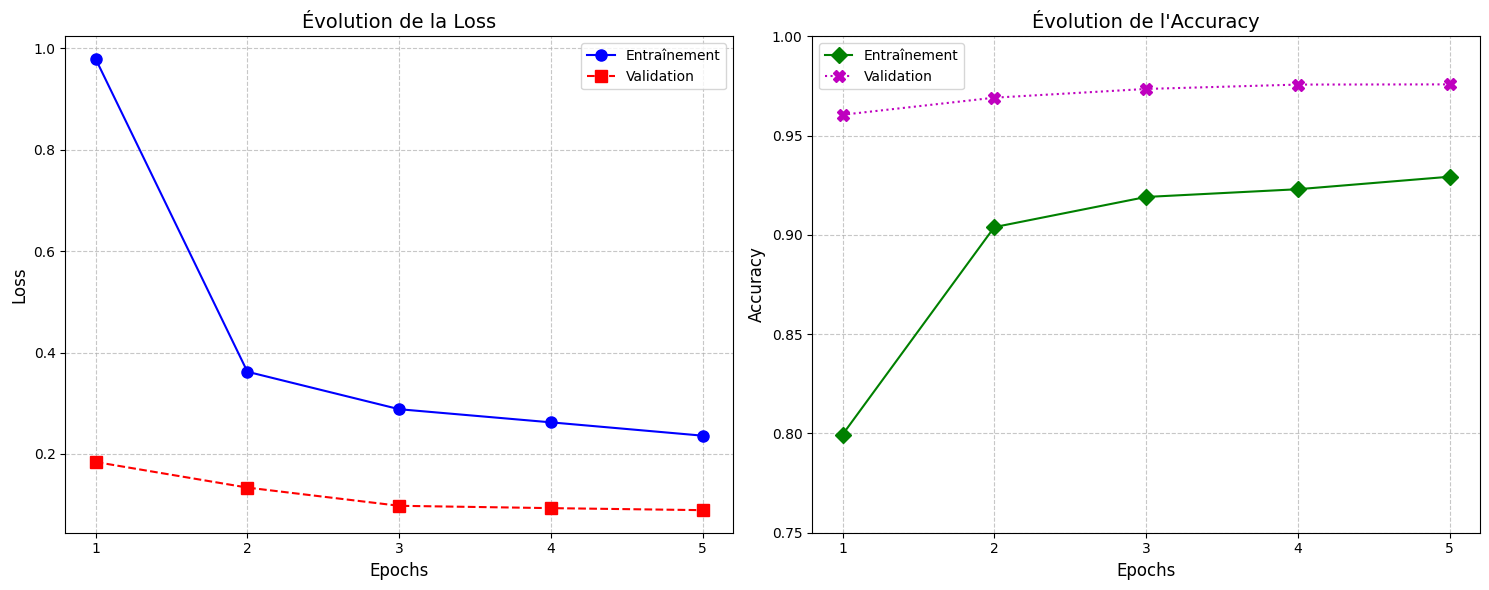

In [27]:
# Correction du NameError et ajout des visualisations
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Évaluation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"\nAccuracy globale: {accuracy:.2f}%")
    
    # Matrice de confusion
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calcul de l'accuracy par classe
    class_acc = {}
    for i, class_name in enumerate(test_dataset.classes):
        class_acc[class_name] = 100 * cm[i,i] / cm[i].sum()
    
    return accuracy, class_acc  # Retourner les deux valeurs

# Exécution avec récupération des deux valeurs
accuracy, class_acc = evaluate(model, test_loader)

# Visualisation de l'accuracy par classe
plt.figure(figsize=(15, 25))
plt.barh(list(class_acc.keys()), list(class_acc.values()))
plt.xlabel('Accuracy (%)')
plt.title('Performance par classe')
plt.show()

# Ajout des courbes d'apprentissage (si disponibles)
# (Ces valeurs doivent être collectées pendant l'entraînement)
# Correction des listes de métriques
train_losses = [0.9792, 0.3621, 0.2882, 0.2623, 0.2360]
val_losses = [0.1841, 0.1336, 0.0977, 0.0931, 0.0891]
train_accs = [0.7994, 0.9039, 0.9191, 0.9230, 0.9293]
val_accs = [0.9605, 0.9691, 0.9735, 0.9757, 0.9758]
epochs = range(1, len(train_losses)+1)

# Visualisation améliorée
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', markersize=8, label='Entraînement')
plt.plot(epochs, val_losses, 'r--s', markersize=8, label='Validation')
plt.title('Évolution de la Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'g-D', markersize=8, label='Entraînement')
plt.plot(epochs, val_accs, 'm:X', markersize=8, label='Validation') 
plt.title("Évolution de l'Accuracy", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.75, 1.0)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


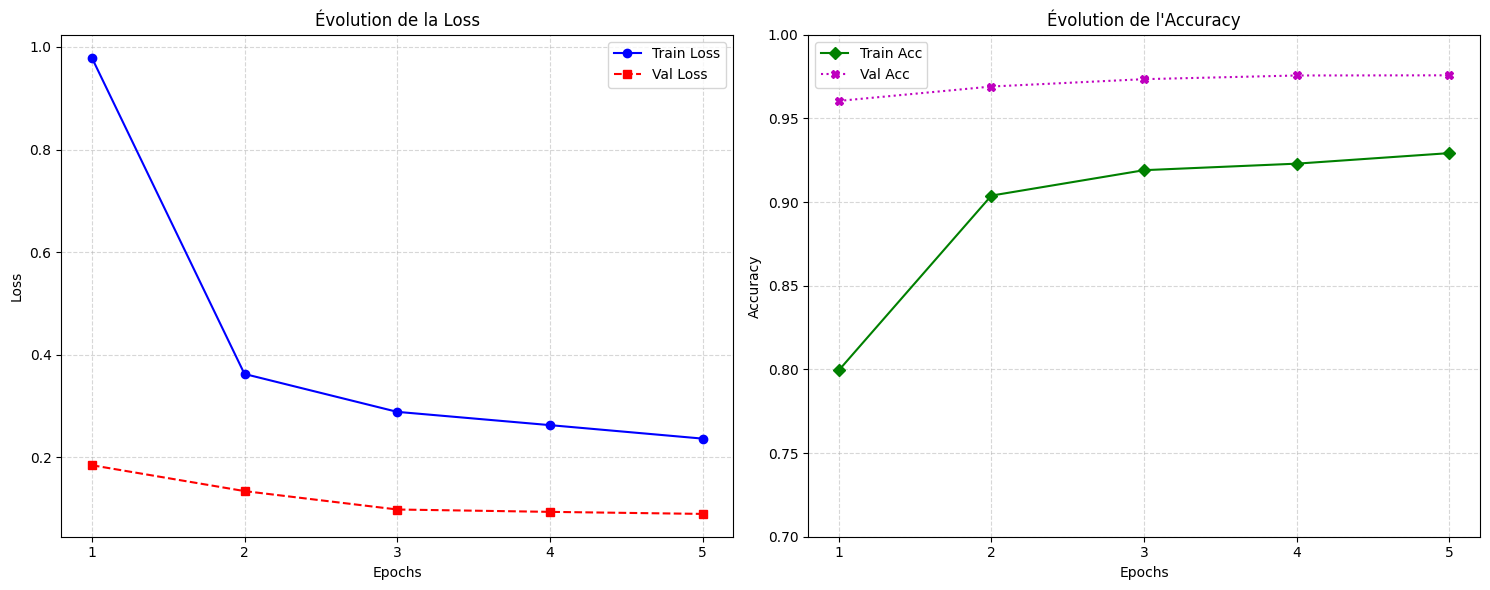

Résumé des performances:
Val Loss finale: 0.0891
Val Accuracy finale: 97.58%
Différence Train/Val finale: 0.0465


In [25]:
import matplotlib.pyplot as plt

# Récupérer les données de vos logs d'entraînement
train_losses = [0.9792, 0.3621, 0.2882, 0.2623, 0.2360]
val_losses = [0.1841, 0.1336, 0.0977, 0.0931, 0.0891]
train_accs = [0.7994, 0.9039, 0.9191, 0.9230, 0.9293]
val_accs = [0.9605, 0.9691, 0.9735, 0.9757, 0.9758]
epochs = range(1, 6)

# Créer une figure avec deux sous-graphiques
plt.figure(figsize=(15, 6))

# Graphique 1: Évolution des Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r--s', label='Val Loss')
plt.title('Évolution de la Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Graphique 2: Évolution de l'Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'g-D', label='Train Acc')
plt.plot(epochs, val_accs, 'm:X', label='Val Acc')
plt.title('Évolution de l\'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()

# Analyse des performances
print("Résumé des performances:")
print(f"Val Loss finale: {val_losses[-1]:.4f}")
print(f"Val Accuracy finale: {val_accs[-1]*100:.2f}%")
print(f"Différence Train/Val finale: {val_accs[-1]-train_accs[-1]:.4f}")

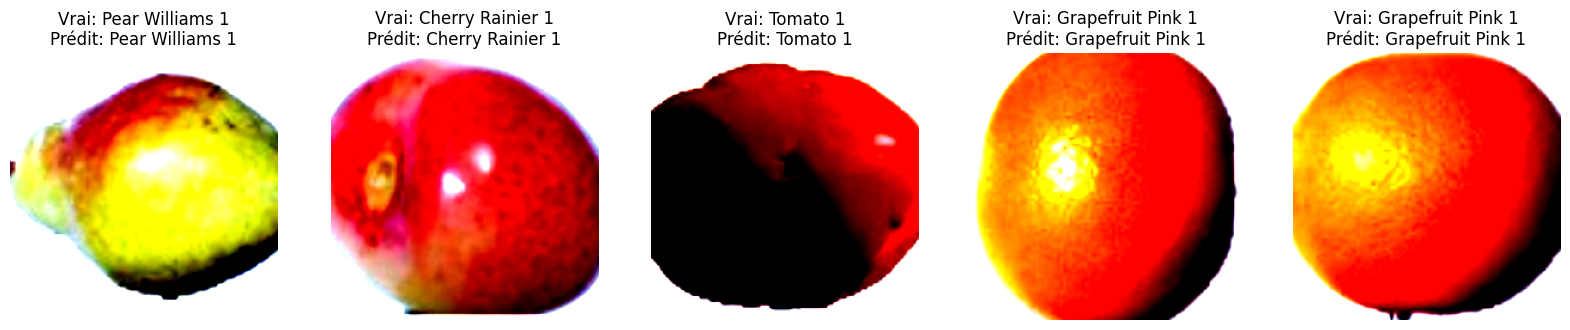

In [18]:
# Afficher quelques prédictions
def show_predictions(num_samples=5):
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(test_dataset))
        image, label = test_dataset[idx]
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, pred = torch.max(output, 1)
        
        axes[i].imshow(image.permute(1, 2, 0).cpu().numpy())
        axes[i].set_title(f"Vrai: {test_dataset.classes[label]}\nPrédit: {test_dataset.classes[pred.item()]}")
        axes[i].axis('off')
    
    plt.show()

show_predictions()

In [30]:
# Dans votre notebook :
File -> Download Notebook (.ipynb)

SyntaxError: invalid syntax (<ipython-input-30-330bd6423c69>, line 2)